In [1]:
import random
import os
import glob
import json
import csv
import time
import shutil
import math
import json
from itertools import combinations, product, islice

import pandas as pd
import numpy as np
from multiprocessing import Pool, Lock, cpu_count
from concurrent.futures import ThreadPoolExecutor
from scipy import stats

In [2]:
# configure path to the data
current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, "..", "data")
data_path = os.path.normpath(data_path)
print(data_path)

/home/dk/Desktop/space_weather_econ/data


In [3]:
# read the business and economic data at zcta and state levels
data_zcta_path = os.path.join(data_path, "NAICS_EST_GDP2022_ZCTA.csv")
population_df_path = os.path.join(data_path, "2020_decennial_census_at_ZCTA_level.csv")

# Reading data
data_zcta = pd.read_csv(data_zcta_path)
population_df = pd.read_csv(population_df_path)

# Merging and aggregating data
unique_zcta_regions = data_zcta[['ZCTA', 'REGIONS', "STABBR"]].drop_duplicates()
regions_pop_df = unique_zcta_regions.merge(population_df, on=["ZCTA", "STABBR"])
total_pop_regions = regions_pop_df.groupby("REGIONS")['POP20'].sum().reset_index()

sum_total_pop = total_pop_regions.POP20.sum()
total_pop_regions["POP20Ratio"] = total_pop_regions.POP20 / sum_total_pop
total_pop_regions

,REGIONS,POP20,POP20Ratio
0,CAISO,36669676,0.112628
1,ERCOT,25756383,0.079109
2,FRCC,20269759,0.062257
3,ISONE,14160438,0.043493
4,MISO,44656227,0.137158
5,NYISO,21994860,0.067556
6,NorthernGridConnected,16095613,0.049437
7,NorthernGridUnconnected,4593872,0.014110
8,NotOrder1000,2506448,0.007698
9,PJM,65742117,0.201922


### Business counts and GDP contribution by NAICs Classification
In our calculation, we assume uniform every person/business contribute equally to State GDP.

In [75]:
# zcta
df_business = (
    data_zcta.groupby(["REGIONS", "NAICS"])[["EST", "GDP2022"]].sum().reset_index()
)

df_business.GDP2022 = df_business.GDP2022 / 1000
sum_total_gdp = df_business.GDP2022.sum() * 1 / 365

total_est_by_naics = df_business.groupby('NAICS')['EST'].sum().sum()

df_business["DailyGDP"] = df_business.GDP2022.map(lambda x: (x / 365))
df_business["ESTPerc"] = df_business.apply(lambda row: row["EST"] / total_est_by_naics, axis=1)

c.head(5)

,REGIONS,NAICS,EST,GDP2022,DailyGDP,ESTPerc
0,CAISO,11,1254.0,39.43982,0.108054,0.000157
1,CAISO,21,257.0,11.34556,0.031084,0.000032
2,CAISO,22,552.0,50.75763,0.139062,0.000069
3,CAISO,23,75608.0,131.64455,0.360670,0.009465
4,CAISO,31,33696.0,380.64336,1.042859,0.004218


In [266]:
df_business.groupby("NAICS")["GDP2022"].sum()

NAICS
11         269.82761
21         444.97046
22         434.64109
23        1081.59229
31        2646.32112
42        1541.87076
44        1610.15894
48         905.70837
51        1388.81947
52        1927.51134
53        3373.06957
54        2006.81272
55         478.71720
56         816.49628
61         292.11447
62        1843.82789
71         269.54517
72         798.70625
81         540.86407
UNCLFD     597.97683
Name: GDP2022, dtype: float64

In [76]:
# Export the business data as a dictionary
nested_dict = {}
region_pop = total_pop_regions.set_index("REGIONS")[["POP20", "POP20Ratio"]]

for _, row in df_business.iterrows():
    region = row["REGIONS"]
    naics = row['NAICS']

    if region not in nested_dict:
        nested_dict[region] = {"NAICS": {}, "POP20": region_pop.loc[region]["POP20"], "POP20Ratio": region_pop.loc[region]["POP20Ratio"]}

    nested_dict[region]["NAICS"][naics] = {'EST': row['EST'], "ESTPerc": row["ESTPerc"], 'DAILYGDP': row['DailyGDP']}


## Estimates of the number of businesses and population without power

In [77]:
# Regions and their possible states (0 or 1)
# states denote all regions with or without power
regions = df_business.REGIONS.unique()

# 0 with power in the entire block, 1 without power
states = [0, 1]

# Generate all possible combinations
combinations = list(product(states, repeat=len(regions)))
df_combinations = pd.DataFrame(combinations, columns=list(df_business.REGIONS.unique()))
df_combinations

,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,NotOrder1000,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
32764,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
32765,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
32766,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [78]:
df_bus_sum = df_business.groupby("REGIONS")[["EST", "DailyGDP", "ESTPerc"]].sum().reset_index()
df_bus_po = df_bus_sum.merge(total_pop_regions, on="REGIONS")
df_bus_po["DailyGDPPerc"] = df_bus_po["DailyGDP"] / sum_total_gdp
df_index = df_bus_po.set_index("REGIONS")

#  save the grid regions quant figures
df_index.to_csv(os.path.join(data_path, "grid_data.csv"))

In [79]:
# transpose the business df and cast on the combinatioons df
transposed_df = df_index.T
transposed_df

REGIONS,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,NotOrder1000,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled
EST,9.302580e+05,5.713920e+05,5.847680e+05,3.663680e+05,1.051459e+06,5.859790e+05,4.633720e+05,1.114560e+05,5.075600e+04,1.550176e+06,6.614400e+04,8.915730e+05,3.596550e+05,2.398830e+05,1.647360e+05
DailyGDP,8.620353e+00,5.467883e+00,3.453930e+00,3.106252e+00,7.836202e+00,5.617152e+00,3.377840e+00,8.291429e-01,4.238074e-01,1.255170e+01,4.032085e-01,6.530127e+00,2.637871e+00,1.708185e+00,1.188548e+00
ESTPerc,1.164573e-01,7.153152e-02,7.320604e-02,4.586494e-02,1.316302e-01,7.335764e-02,5.800869e-02,1.395297e-02,6.354051e-03,1.940637e-01,8.280447e-03,1.116144e-01,4.502455e-02,3.003051e-02,2.062300e-02
POP20,3.666968e+07,2.575638e+07,2.026976e+07,1.416044e+07,4.465623e+07,2.199486e+07,1.609561e+07,4.593872e+06,2.506448e+06,6.574212e+07,2.695532e+06,3.995916e+07,1.434230e+07,9.947333e+06,6.191785e+06
POP20Ratio,1.126283e-01,7.910886e-02,6.225710e-02,4.349276e-02,1.371584e-01,6.755562e-02,4.943651e-02,1.410975e-02,7.698374e-03,2.019222e-01,8.279131e-03,1.227317e-01,4.405134e-02,3.055251e-02,1.901762e-02
DailyGDPPerc,1.352166e-01,8.576776e-02,5.417743e-02,4.872384e-02,1.229166e-01,8.810915e-02,5.298390e-02,1.300572e-02,6.647730e-03,1.968826e-01,6.324622e-03,1.024298e-01,4.137694e-02,2.679413e-02,1.864325e-02


The business dataframe consist of total number of the employed, establishments, and population in grid regions

In [80]:
# broadcast the emp, population, and establishment on the combination df
array_transposed = transposed_df.to_numpy()
array_comb = df_combinations.to_numpy()

result_array = array_transposed[:, np.newaxis, :] * array_comb

In [81]:
# store employment, establishments, pop, and daily GDP
indices = list(transposed_df.index)

for i, indx in enumerate(indices):
    print(indx)
    # create dataframes dynamically
    globals()[f"df_{indx}"] = pd.DataFrame(result_array[i], columns=list(regions))

# establishment without power
df_EST["ESTAgg"] = df_EST.sum(axis=1)

# establishment without power (percent)
df_ESTPerc["ESTPercAgg"] = df_ESTPerc.sum(axis=1)

# Aggregate of the daily GDP shock (Percent)
df_DailyGDP["DailyGDPAgg"] = df_DailyGDP.sum(axis=1)

# Population affected
df_POP20["POP20Agg"] = df_POP20.sum(axis=1)

# Population affected Percentage
df_POP20Ratio["POP20RatioAgg"] = df_POP20Ratio.sum(axis=1)

EST
DailyGDP
ESTPerc
POP20
POP20Ratio
DailyGDPPerc


In [82]:
df_EST.head(5)

,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,NotOrder1000,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled,ESTAgg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164736.0,164736.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239883.0,0.0,239883.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239883.0,164736.0,404619.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,359655.0,0.0,0.0,359655.0


3993987.5

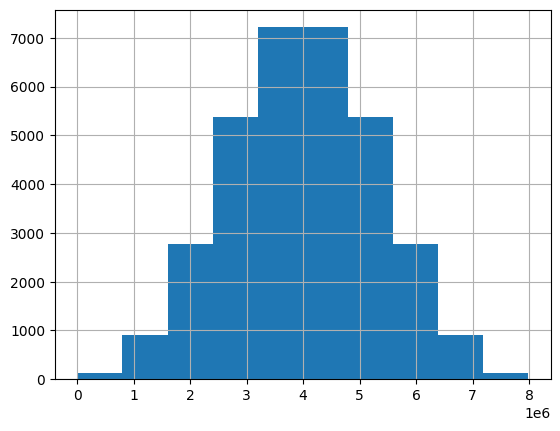

In [83]:
# Est without power
df_EST["ESTAgg"].hist()

df_EST.ESTAgg.quantile(0.5)

63.75219698630138

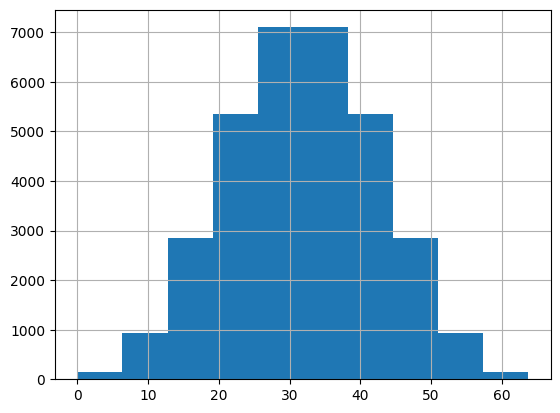

In [128]:
# Aggregate of daily GDP without power
df_DailyGDP["DailyGDPAgg"].hist()
df_DailyGDP["DailyGDPAgg"].quantile(1)

73719531.5

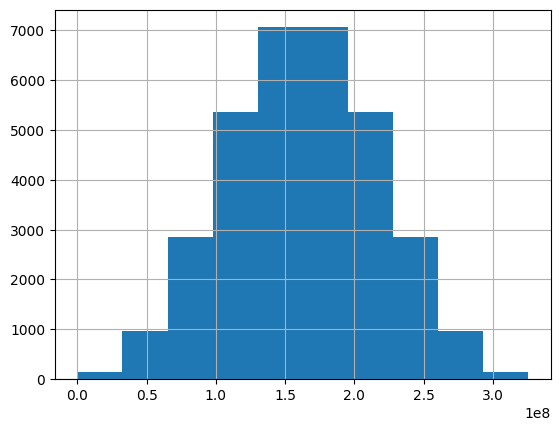

In [140]:
df_POP20["POP20Agg"].hist()
df_POP20["POP20Agg"].quantile(0.05)

### Extract Indices, Rows, and Sum Total of the Percentiles

In [234]:
percentiles = np.linspace(0, 60, 5)

# Generate column names based on percentiles for the number of establishments
column_names = [f"perc{int(i)}" if i != 0 else 'perc0' for i in percentiles]

def get_percentiles(df, column):
    # calculate the percentile values
    percentile_values = np.percentile(df[column], percentiles)

    # function to find the closest value in an array
    def find_closest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    # Find the closest values in the dataframe for each percentile
    closest_values = [
        find_closest(df[column], pv) for pv in percentile_values
    ]

    # Extract the rows that have these closest values
    extracted_rows = df[df[column].isin(closest_values)].sort_values(
        by=column
    )
    
    return extracted_rows

In [235]:
data_agg = "POP20RatioAgg"

pop_perc = get_percentiles(df_POP20Ratio, data_agg)
pop_perc = pop_perc.T
pop_perc.columns = column_names
pop_perc.drop(data_agg, inplace=True)

pop_perc.head(5)

# save the percentages
pop_perc.to_csv(os.path.join(data_path, "pop_perc.csv"))

In [236]:
# def calculate_percentiles_and_transform(df, data_type, data_agg, nested_dict, percentiles, column_names, TYPE):
#     # Calculate percentiles and transform
#     percentiles_data = get_percentiles(df, data_agg)
#     percentiles_transformed = percentiles_data.T
#     percentiles_transformed.columns = column_names
#     percentiles_transformed.drop(data_agg, inplace=True)

#     # Create new rows classified by NAICS codes using nested_dict
#     new_rows = []
#     new_col_names = ["REGIONS", "NAICS"]

#     for reg, row in percentiles_transformed.iterrows():
#         non_zero_indices = [i for i, value in enumerate(row) if value != 0]

#         for naics, data in nested_dict[reg]["NAICS"].items():
#             new_row = [reg, naics] + [data[data_type] if i in non_zero_indices else 0 for i in range(len(row))]
#             new_rows.append(new_row)

#     # Creating the final DataFrame
#     new_col_names.extend(column_names)
    
#     percentiles_df = pd.DataFrame(new_rows, columns=new_col_names)
    
#     dfs = (percentiles_df, percentiles_transformed)
    
#     return percentiles_df

# column_names = [f"perc{int(i)}" if i != 0 else 'perc0' for i in percentiles]



In [237]:
#  Use the population/ firms estimates

total_val = df_index.EST.sum()

# Target population percentages
targets = percentiles / 100

def get_closest_values(df, col, colAgg, total_val, targets=targets):

    # Calculate target population values
    target_values = [total_val * t for t in targets]
    col_names = [f"perc{int(target * 100)}" for target in targets]

    # Find scenarios closest to each target value
    closest_scenarios = pd.DataFrame()

    for target in target_values:
        df['Difference'] = abs(df[colAgg] - target)
        closest_scenario = df[df['Difference'] == df['Difference'].min()]
        closest_scenarios = pd.concat([closest_scenarios, closest_scenario])

    # Drop the 'Difference' column if no longer needed
    closest_scenarios = closest_scenarios.drop(columns=['Difference'])
    
    percentiles_transformed = closest_scenarios.T
    percentiles_transformed.columns = col_names
    percentiles_transformed.drop(colAgg, inplace=True)

    # Create new rows classified by NAICS codes using nested_dict
    new_rows = []
    new_col_names = ["REGIONS", "NAICS"]

    for reg, row in percentiles_transformed.iterrows():
        non_zero_indices = [i for i, value in enumerate(row) if value != 0]

        for naics, data in nested_dict[reg]["NAICS"].items():
            new_row = [reg, naics] + [data[col] if i in non_zero_indices else 0 for i in range(len(row))]
            new_rows.append(new_row)

    # Creating the final DataFrame
    new_col_names.extend(col_names)

    percentiles_df = pd.DataFrame(new_rows, columns=new_col_names)

    dfs = (percentiles_df, percentiles_transformed)
    
    return percentiles_df

naics_perc_df_est_raw = get_closest_values(df_EST, "EST", "ESTAgg", total_val)
naics_perc_df_estperc_raw = get_closest_values(df_ESTPerc, "ESTPerc", "ESTPercAgg", total_val)

#  Total GDP and Population
total_gdp = df_business.GDP2022.sum()
total_pop = total_pop_regions.POP20.sum()

# classify by regions
regions_perc_df_est = naics_perc_df_est_raw.drop("NAICS", axis=1).groupby("REGIONS").sum() / 1000000
regional_pop = pop_perc * total_pop/1000000
regional_pop.index.name = 'REGIONS'

# save the establishments, population, and gdp in the regions
regions_perc_df_est.to_csv(os.path.join(data_path,"est_regions.csv"))
regional_pop.to_csv(os.path.join(data_path,"pop_regions.csv"))

# classify by naics
naics_perc_df_est = naics_perc_df_est_raw.drop("REGIONS", axis=1).groupby("NAICS").sum()
naics_perc_df_estperc = naics_perc_df_estperc_raw.drop("REGIONS", axis=1).groupby("NAICS").sum()

In [263]:
# Get the GDP shocks from the establishments by NAICs for input output modeling
df_business_copy = df_business.copy()
df_business_copy.set_index(["REGIONS","NAICS"], inplace = True)

naics_perc_df_est_raw_copy = naics_perc_df_est_raw.copy()
naics_perc_df_est_raw_copy.set_index(["REGIONS","NAICS"], inplace = True)

naics_perc_df_est_raw_copy_bin = naics_perc_df_est_raw_copy.ne(0).astype(int)
naics_perc_df_est_raw_copy_bin

# GDP shock due to loss for a given population without power scenarios
gdp_shock_naics = naics_perc_df_est_raw_copy_bin.apply(lambda row: row * df_business_copy.loc[row.name, 'DailyGDP'], axis=1)
gdp_shock_naics_grp = gdp_shock_naics.groupby("NAICS").sum()

# save the GDP shocks by NAICs for the given establishments
gdp_shock_naics_grp.to_csv(os.path.join(data_path, "input_output", "GDP_shocks_est.csv"))

# get the shocks as percentages and save
gdp_shock_naics_grp_perc = gdp_shock_naics_grp / df_index.DailyGDP.sum()
gdp_shock_naics_grp_perc.to_csv(os.path.join(data_path, "results", "supply", "shocks_perc.csv"))
gdp_shock_naics_grp.to_csv(os.path.join(data_path, "results", "supply", "GDP_shocks_est.csv"))

In [264]:
# Demand side

# Population without power
pop_binary = regional_pop.copy()
pop_binary = pop_binary.ne(0).astype(int)

# GDP shock due to loss for a given population without power scenarios
gdp_loss_pop_df = pop_binary.apply(lambda row: row * df_index.loc[row.name, 'DailyGDP'], axis=1).round(2)

# Establishments without power in for a given set of population scenarios without power
est_pop_df = (pop_binary.apply(lambda row: row * df_index.loc[row.name, 'EST'], axis=1) / 1000000).round(2)

# Save the DataFrames for given population scenarios
gdp_loss_pop_df.to_csv(os.path.join(data_path, "regions_gdp_loss_pop_scenarios.csv"))
est_pop_df.to_csv(os.path.join(data_path, "regions_est_pop_scenarios.csv"))

In [265]:
# supply side

# Establishments without power
est_binary = regions_perc_df_est.copy()
est_binary = est_binary.ne(0).astype(int)

# GDP shock due to loss of power for a given number of establishments in grid regions
gdp_loss_est_df = est_binary.apply(lambda row: row * df_index.loc[row.name, 'DailyGDP'], axis=1).round(2)
# Percentages of daily Output
gdp_loss_est_df_perc = (gdp_loss_est_df / df_business.DailyGDP.sum()).round(2)

# population without power for a given set of est scenarios without power
pop_est_df = (est_binary.apply(lambda row: row * df_index.loc[row.name, 'POP20'], axis=1) / 1000000).round(2)
# population percentages
pop_est_df_perc = (pop_est_df / df_index.POP20.sum()).round(2)

# Save the dfs for given population scenarios
gdp_loss_est_df.to_csv(os.path.join(data_path,"results", "supply", "gdp_loss_est.csv"))
gdp_loss_est_df_perc.to_csv(os.path.join(data_path,"results", "supply","gdp_loss_est_perc.csv"))
pop_est_df.to_csv(os.path.join(data_path, "results", "supply","pop_est.csv"))
pop_est_df_perc.to_csv(os.path.join(data_path, "results", "supply","pop_perc.csv"))

In [ ]:
# combine dataframes and export to JSON file
data = {
    "Population as percentages": pop_perc.to_dict(),
    "Establishments by NAICS": naics_perc_df_est.to_dict(),
    "Percentage of Daily GDP Shocks by NAICS": naics_perc_df_gdp.to_dict(),
    "Establishments as percentages": naics_perc_df_estperc.to_dict(),
}

# save the dfs
file_path = os.path.join(data_path, 'data.json')

# Writing dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)
    naics_perc_df_gdp
    
# Save each dataframe to a CSV file
for key, df in zip(data.keys(), [pop_perc, naics_perc_df_est, naics_perc_df_gdp, naics_perc_df_estperc]):
    csv_path = os.path.join(data_path, key.lower() + ".csv")
    df.to_csv(csv_path, index=False)

### Loss Estimation by Randomly Assigning Percentage of Businesses and Population without Power - TBD

In [6]:
# # simplifiied code for GDP Loss estimation
# def compute_GDP_loss(df, baseline_failures: list, time: int = 24):
#     """
#     Computes the GDP loss due to a power failure.

#     Parameters:
#     baseline_failures (list): List of percentages of the population affected by the power failure.
#     time (int): The duration of the power failure in hours.

#     Returns:
#     DataFrame: A DataFrame with regions and their corresponding GDP losses under the scenario
#     for all population without power.
#     """
#     scenarios = []
#     for f in baseline_failures:
#         # scenario string
#         scenario_str = f"scenario_{int(f * 100)}f_{time}h"
#         # add column to scenarios list
#         scenarios.append(scenario_str)

#         # calculating GDP string
#         df[scenario_str] = df["daily_GDP"].map(lambda x: x * f * (time / 24))

#     scenarios.extend(["REGIONS"])
#     scenarios.reverse()

#     return df[scenarios]


# # List of baseline failure rates
# baseline_failures = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.975, 1]

# df_est_loss = compute_GDP_loss(df_business, baseline_failures)

In [7]:
# df_est_loss.head(10)

,REGIONS,scenario_100f_24h,scenario_97f_24h,scenario_75f_24h,scenario_50f_24h,scenario_25f_24h,scenario_10f_24h,scenario_5f_24h,scenario_2f_24h,scenario_1f_24h
0,CAISO,8017.987086,7817.537409,6013.490314,4008.993543,2004.496771,801.798709,400.899354,200.449677,80.179871
1,ERCOT,4656.952155,4540.528351,3492.714116,2328.476078,1164.238039,465.695216,232.847608,116.423804,46.569522
2,FRCC,3141.594334,3063.054476,2356.195751,1570.797167,785.398584,314.159433,157.079717,78.539858,31.415943
3,ISONE,2937.949888,2864.501141,2203.462416,1468.974944,734.487472,293.794989,146.897494,73.448747,29.379499
4,MISO,7023.760705,6848.166687,5267.820529,3511.880352,1755.940176,702.376070,351.188035,175.594018,70.237607
5,NYISO,5167.930314,5038.732056,3875.947736,2583.965157,1291.982579,516.793031,258.396516,129.198258,51.679303
6,NorthernGridConnected,2930.427306,2857.166623,2197.820480,1465.213653,732.606827,293.042731,146.521365,73.260683,29.304273
7,NorthernGridUnconnected,934.480353,911.118344,700.860265,467.240176,233.620088,93.448035,46.724018,23.362009,9.344804
8,NotOrder1000,545.395416,531.760531,409.046562,272.697708,136.348854,54.539542,27.269771,13.634885,5.453954
9,PJM,11555.533987,11266.645637,8666.650490,5777.766993,2888.883497,1155.553399,577.776699,288.888350,115.555340


In [70]:
# # sum of daily economic losses in millions for the given scenarios
# cols = list(df_est_loss.columns)[1:]

# df_est_loss[cols].sum(axis=0)

scenario_100f_24h    58382.108920
scenario_97f_24h     56922.556197
scenario_75f_24h     43786.581690
scenario_50f_24h     29191.054460
scenario_25f_24h     14595.527230
scenario_10f_24h      5838.210892
scenario_5f_24h       2919.105446
scenario_2f_24h       1459.552723
scenario_1f_24h        583.821089
dtype: float64

### Uncertainty Quantification

In the previous model, we assume equal percentages of populations within the regions to be affected without power. 
Some regions are more vulnerable or least resilient to space weather.

In [100]:
# def rand_without_power(df, time=24, num_simulations_list=[999], max_failure=1):
#     # simulation columns
#     sim_cols = []

#     # loop over the number of permutations given
#     for num_simulations in num_simulations_list:
#         # running Monte Carlo simulations
#         simulation_results = []

#         for _ in range(num_simulations):
#             # randomly selecting failure rate of a region (0-1)
#             failure_probability = np.random.rand() * max_failure

#             # calculating the GDP loss for each region with the randomly selected probability
#             result = df["daily_GDP"].map(
#                 lambda x: x * failure_probability * (time / 24)
#             )
#             simulation_results.append(result)

#         # calculate the average result from all simulations
#         avg_simulation_result = pd.concat(simulation_results, axis=1).mean(axis=1)
#         sim_str = f"avg_loss_{num_simulations}_sim"
#         df[sim_str] = avg_simulation_result

#         sim_cols.append(sim_str)

#     sim_cols.extend(["REGIONS"])
#     sim_cols.reverse()

#     return df[sim_cols]


# # Example Usage
# simulations_list = [999, 9999, 99999]

# # taking the maximum number of people in a population without power is 50%
# df_simulations = rand_without_power(
#     df_business, time=24, num_simulations_list=simulations_list, max_failure=1
# )

# df_simulations.head(5)

,REGIONS,avg_loss_99999_sim,avg_loss_9999_sim,avg_loss_999_sim
0,CAISO,4003.327235,4021.590764,3928.893238
1,ERCOT,2325.185012,2335.792709,2281.952769
2,FRCC,1568.577004,1575.732989,1539.412399
3,ISONE,1466.898696,1473.590817,1439.624600
4,MISO,3506.916664,3522.915525,3441.712445


In [102]:
# sum of the simulations
cols = list(df_simulations.columns)
cols.remove("REGIONS")

df_simulations[cols].sum(axis=0)

avg_loss_99999_sim    29149.795849
avg_loss_9999_sim     29282.779769
avg_loss_999_sim      28607.812719
dtype: float64

### Considering Each Region Differ in Population without Power

In [103]:
def rand_without_power_ind(df, time=24, num_simulations_list=[999], max_failure=1):
    "Make failure rate in the region independent of each other"

    # simulation columns
    sim_cols = []

    # loop over the number of permutations given
    for num_simulations in num_simulations_list:
        # running Monte Carlo simulations
        simulation_results = []

        for _ in range(num_simulations):
            # randomly selecting failure rate of a region (0-1)
            failure_probabilities = (
                np.random.rand() * max_failure
            )  # add maximum failure rate
            gdp_losses = (
                df["daily_GDP"] * failure_probabilities * (time / 24)
            )  # include period without power

            simulation_results.append(gdp_losses)

        # calculate the average result from all simulations
        avg_simulation_result = pd.concat(simulation_results, axis=1).mean(axis=1)
        sim_str = f"avg_loss_{num_simulations}_sim"
        df[sim_str] = avg_simulation_result

        sim_cols.append(sim_str)

    sim_cols.extend(["REGIONS"])
    sim_cols.reverse()

    return df[sim_cols]


# Example Usage
simulations_list = [999, 9999, 99999]

# taking the maximum number of people in a population without power is 50%
df_simulations = rand_without_power(
    df_business, time=24, num_simulations_list=simulations_list, max_failure=1
)

df_simulations.head(5)

,REGIONS,avg_loss_99999_sim,avg_loss_9999_sim,avg_loss_999_sim
0,CAISO,4005.007635,4002.104147,3980.545546
1,ERCOT,2326.161010,2324.474626,2311.953107
2,FRCC,1569.235415,1568.097775,1559.650720
3,ISONE,1467.514428,1466.450532,1458.551032
4,MISO,3508.388695,3505.845238,3486.959893


In [104]:
# sum of the simulations
cols = list(df_simulations.columns)
cols.remove("REGIONS")

df_simulations[cols].sum(axis=0)

avg_loss_99999_sim    29162.031502
avg_loss_9999_sim     29140.890063
avg_loss_999_sim      28983.913434
dtype: float64